Iteration 1, diff = 24130.303525
Iteration 2, diff = 16702.131863
Iteration 3, diff = 13516.602423
Iteration 4, diff = 10477.726622
Iteration 5, diff = 9159.748791
Iteration 6, diff = 7727.869230
Iteration 7, diff = 7043.401380
Iteration 8, diff = 6275.466575
Iteration 9, diff = 5854.770689
Iteration 10, diff = 5392.371165
Iteration 11, diff = 5097.333622
Iteration 12, diff = 4824.054352
Iteration 13, diff = 4612.863455
Iteration 14, diff = 4334.715209
Iteration 15, diff = 4151.875871
Iteration 16, diff = 3942.528657
Iteration 17, diff = 3779.397433
Iteration 18, diff = 3613.640543
Iteration 19, diff = 3465.930928
Iteration 20, diff = 3320.328251
Iteration 21, diff = 3186.003811
Iteration 22, diff = 3055.235999
Iteration 23, diff = 2932.304575
Iteration 24, diff = 2813.422601
Iteration 25, diff = 2700.540774
Iteration 26, diff = 2591.759613
Iteration 27, diff = 2487.924440
Iteration 28, diff = 2388.044592
Iteration 29, diff = 2292.444080
Iteration 30, diff = 2200.572953
Iteration 31, d

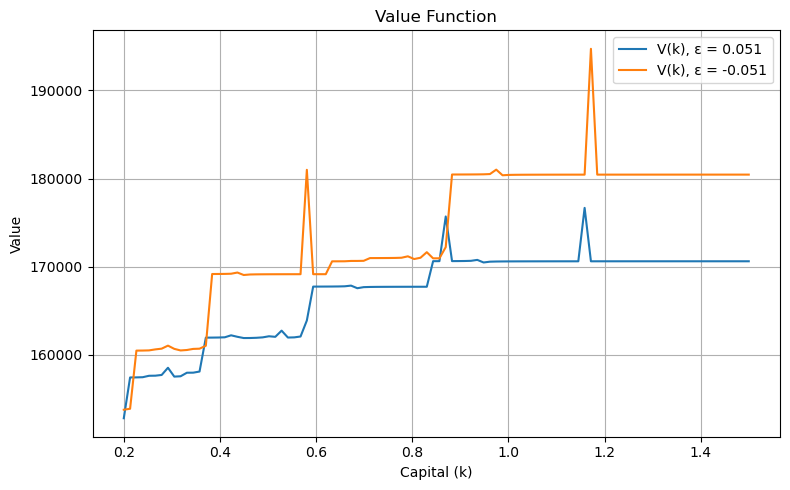

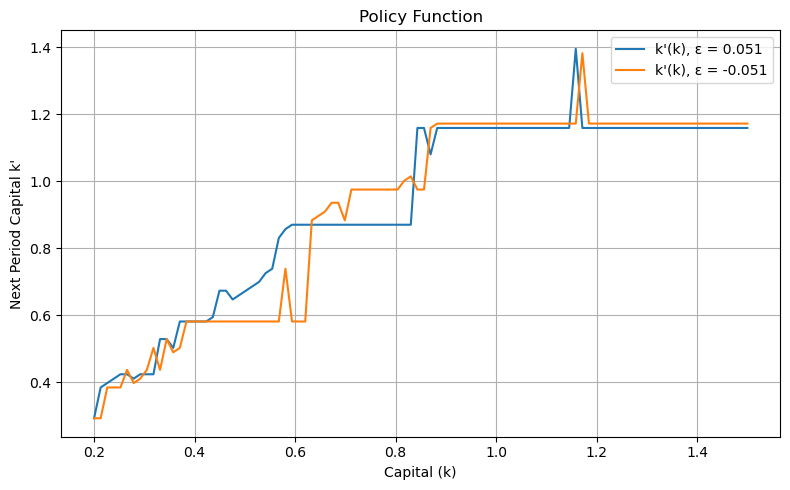

In [1]:
# part b value function iteration

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# parameters
beta = 0.96
alpha = 0.33
theta = 1.0
gamma = 2.0
B = 0.075
omega = 2
A = 0.592
epsilon_vals = np.array([0.051, -0.051])  # ε1 = -ε2 = Θ
pi = np.array([[0.72, 0.28], [0.28, 0.72]])  # transition matrix

# capital grid
k_min = 0.2
k_max = 1.5
nk = 100
k_grid = np.linspace(k_min, k_max, nk)

# utility function
def utility(c, l):
    if c <= 0 or l <= 0:
        return -1e10
    return ((c - l**(1 + theta) / (1 + theta))**(1 - gamma)) / (1 - gamma)

# production function
def production(k, h, l):
    return A * (k * h)**alpha * l**(1 - alpha)

# depreciation function
def depreciation(h):
    return B * (h**omega) / omega

# optimize h and l jointly 
def optimize_hiring(k_i, epsilon):
    def objective(x):
        h, l = x
        if h <= 0 or l <= 0:
            return 1e10
        output = production(k_i, h, l)
        depreciation_term = k_i * (1 - depreciation(h)) * np.exp(-epsilon)
        c = output + depreciation_term
        if c <= 0:
            return 1e10
        return -utility(c, l)

    x0 = np.array([0.5, 0.5])
    bounds = [(1e-4, 1.0), (1e-4, 1.0)]
    res = minimize(objective, x0, bounds=bounds, method='L-BFGS-B')

    if res.success:
        return res.x
    else:
        return (0.1, 0.1)

# value function iteration
V = np.zeros((nk, 2))  # V(k, ε)
policy_k = np.zeros((nk, 2))  # optimal k'(k, ε)

max_iter = 500
tol = 1e-4

for it in range(max_iter):
    V_new = np.zeros_like(V)
    policy_k_new = np.zeros_like(policy_k)

    for i_k, k in enumerate(k_grid):
        for i_eps, eps in enumerate(epsilon_vals):
            max_val = -1e10
            best_kp = k_min

            h_opt, l_opt = optimize_hiring(k, eps)

            for kp in k_grid:
                # compute feasible consumption
                output = production(k, h_opt, l_opt)
                depreciation_term = k * (1 - depreciation(h_opt)) * np.exp(-eps)
                c = output - kp * np.exp(-eps) + depreciation_term

                if c <= 0:
                    continue

                u = utility(c, l_opt)

                # expected continuation value
                EV = 0
                for j in range(2):
                    idx_kp = np.clip(np.searchsorted(k_grid, kp), 0, nk - 1)
                    EV += pi[i_eps, j] * V[idx_kp, j]

                val = u + beta * EV

                if val > max_val:
                    max_val = val
                    best_kp = kp

            V_new[i_k, i_eps] = max_val
            policy_k_new[i_k, i_eps] = best_kp

    diff = np.max(np.abs(V - V_new))
    print(f"Iteration {it + 1}, diff = {diff:.6f}")
    V = V_new
    policy_k = policy_k_new

    if diff < tol:
        print("Converged!")
        break

# plotting value and policy functions 
plt.figure(figsize=(8, 5))
for i, eps in enumerate(epsilon_vals):
    plt.plot(k_grid, V[:, i], label=f"V(k), ε = {eps:.3f}")
plt.title("Value Function")
plt.xlabel("Capital (k)")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
for i, eps in enumerate(epsilon_vals):
    plt.plot(k_grid, policy_k[:, i], label=f"k'(k), ε = {eps:.3f}")
plt.title("Policy Function")
plt.xlabel("Capital (k)")
plt.ylabel("Next Period Capital k'")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Policy iteration 1: policy stable? False
Policy iteration 2: policy stable? False
Policy iteration 3: policy stable? False
Policy iteration 4: policy stable? False
Policy iteration 5: policy stable? False
Policy iteration 6: policy stable? False
Policy iteration 7: policy stable? False
Policy iteration 8: policy stable? True
Policy converged.


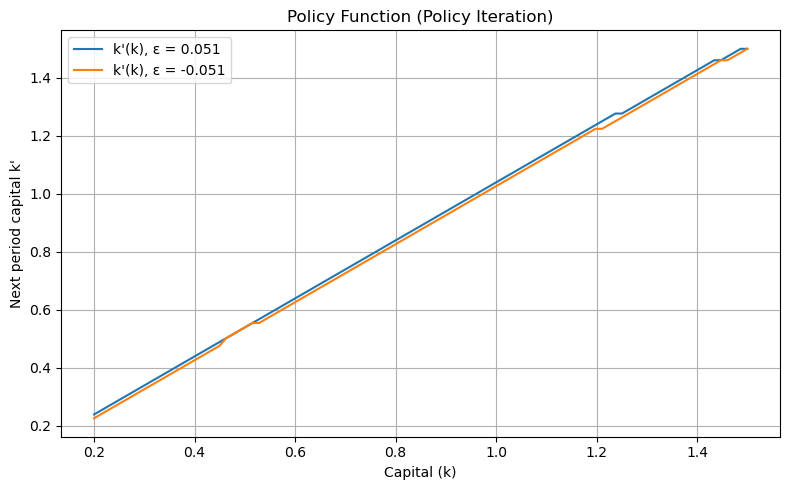

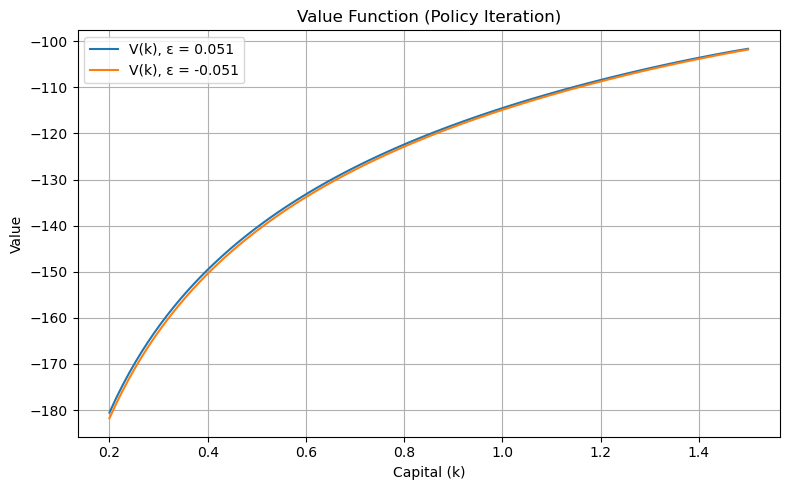

In [2]:
# part d policy function iteration

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# parameters 
beta = 0.96
alpha = 0.33
theta = 1.0
gamma = 2.0
B = 0.075
omega = 2.0
A = 0.592

# shocks and transitions
eps_vals = np.array([0.051, -0.051])
# change pi to your model's transition matrix; here I use symmetric for example
pi = np.array([[0.72, 0.28],
               [0.28, 0.72]])

# grid for k 
k_min = 0.2
k_max = 1.5
nk = 100
k_grid = np.linspace(k_min, k_max, nk)

# functions 
def production(k, h, l):
    return A * (k * h)**alpha * l**(1 - alpha)

def depreciation(h):
    return B * (h**omega) / omega

def utility(c, l):
    # CRRA on (c - disutility_of_labor)
    if c <= 0 or l <= 0:
        return -1e12
    term = c - (l**(1 + theta)) / (1 + theta)
    if term <= 0:
        return -1e12
    return term**(1 - gamma) / (1 - gamma)

# joint optimization for h and l (depends only on k and eps) 
def optimize_h_l(k_i, eps):
    # objective: negative of instantaneous utility (we want to maximize instantaneous utility of the planner's flow)
    def obj(x):
        h, l = x
        if h <= 0 or l <= 0:
            return 1e10
        y = production(k_i, h, l)
        maint = k_i * (1 - depreciation(h)) * np.exp(-eps)
        c = y + maint  # note: the inner optimization per prompt excludes -k' e^{-eps}
        if c <= 0:
            return 1e10
        return -utility(c, l)

    x0 = np.array([0.5, 0.5])
    bounds = [(1e-6, 1.0), (1e-6, 1.0)]
    res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-9})
    if res.success:
        return res.x[0], res.x[1]
    else:
        # fallback safe values
        return 0.1, 0.1

# precompute optimal (h,l) for each (k, eps) because inner optimization does not depend on k'
h_opt_grid = np.zeros((nk, len(eps_vals)))
l_opt_grid = np.zeros_like(h_opt_grid)
for i_k, k in enumerate(k_grid):
    for i_eps, eps in enumerate(eps_vals):
        h_opt_grid[i_k, i_eps], l_opt_grid[i_k, i_eps] = optimize_h_l(k, eps)

# policy iteration setup 
# represent policy as indices into k_grid: policy_idx[i_k, i_eps] gives index j such that k' = k_grid[j]
# initialize policy to "do nothing" k' = k (so policy_idx = i_k)
policy_idx = np.tile(np.arange(nk).reshape(nk, 1), (1, len(eps_vals)))  # shape (nk, 2)

# storage for value function
V = np.zeros((nk, len(eps_vals)))

# PFI parameters
max_policy_iter = 200
tol_policy = 1e-6
max_eval_iter = 2000
tol_eval = 1e-8

for pol_it in range(max_policy_iter):
    # policy evaluation: compute V given current policy (iterative solver) 
    # start with current V as initial guess, then iterate Bellman with k' fixed by policy_idx
    for eval_it in range(max_eval_iter):
        V_new = np.zeros_like(V)
        for i_k, k in enumerate(k_grid):
            for i_eps, eps in enumerate(eps_vals):
                j = policy_idx[i_k, i_eps]  # index of k' chosen by policy
                kprime = k_grid[j]
                h_opt = h_opt_grid[i_k, i_eps]
                l_opt = l_opt_grid[i_k, i_eps]

                # consumption using resource constraint from prompt (includes -k' e^{-eps})
                y = production(k, h_opt, l_opt)
                maint = k * (1 - depreciation(h_opt)) * np.exp(-eps)
                c = y - kprime * np.exp(-eps) + maint

                if c <= 0:
                    flow = -1e12
                else:
                    flow = utility(c, l_opt)

                # expected continuation value: V(k', eps') where k' is fixed by policy (j)
                EV = 0.0
                for s in range(len(eps_vals)):
                    EV += pi[i_eps, s] * V[j, s]
                V_new[i_k, i_eps] = flow + beta * EV

        diff_eval = np.max(np.abs(V_new - V))
        V = V_new
        if diff_eval < tol_eval:
            break
    # end policy evaluation

    # policy Improvement: find best k' for each state given V 
    policy_stable = True
    new_policy_idx = np.copy(policy_idx)
    for i_k, k in enumerate(k_grid):
        for i_eps, eps in enumerate(eps_vals):
            h_opt = h_opt_grid[i_k, i_eps]
            l_opt = l_opt_grid[i_k, i_eps]

            best_val = -1e20
            best_j = policy_idx[i_k, i_eps]

            # search over possible next period capital (discrete grid)
            for j_candidate in range(nk):
                kprime = k_grid[j_candidate]
                y = production(k, h_opt, l_opt)
                maint = k * (1 - depreciation(h_opt)) * np.exp(-eps)
                c = y - kprime * np.exp(-eps) + maint
                if c <= 0:
                    continue  # infeasible
                flow = utility(c, l_opt)

                # expected continuation value using current V
                EV = 0.0
                for s in range(len(eps_vals)):
                    EV += pi[i_eps, s] * V[j_candidate, s]

                val = flow + beta * EV
                if val > best_val:
                    best_val = val
                    best_j = j_candidate

            new_policy_idx[i_k, i_eps] = best_j
            if best_j != policy_idx[i_k, i_eps]:
                policy_stable = False

    policy_idx = new_policy_idx

    print(f"Policy iteration {pol_it+1}: policy stable? {policy_stable}")
    if policy_stable:
        print("Policy converged.")
        break

# convert policy indices to actual k' values for plotting
policy_k = k_grid[policy_idx]

# plot results 
plt.figure(figsize=(8,5))
for i_eps, eps in enumerate(eps_vals):
    plt.plot(k_grid, policy_k[:, i_eps], label=f"k'(k), ε = {eps:.3f}")
plt.xlabel('Capital (k)')
plt.ylabel("Next period capital k'")
plt.title("Policy Function (Policy Iteration)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.figure(figsize=(8,5))
for i_eps, eps in enumerate(eps_vals):
    plt.plot(k_grid, V[:, i_eps], label=f"V(k), ε = {eps:.3f}")
plt.xlabel('Capital (k)')
plt.ylabel('Value')
plt.title('Value Function (Policy Iteration)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



Precomputing inner (h,l) on k-grid ...
done precompute in 0.11s
Starting EGM iterations ...
EGM iter 1: diff_uc = 7.938e+01, recovered endogenous points per eps = [47, 47]
EGM iter 2: diff_uc = 3.120e+01, recovered endogenous points per eps = [66, 66]
EGM iter 3: diff_uc = 1.315e+01, recovered endogenous points per eps = [76, 75]
EGM iter 4: diff_uc = 1.000e+01, recovered endogenous points per eps = [81, 81]
EGM iter 5: diff_uc = 4.061e+01, recovered endogenous points per eps = [84, 85]
EGM iter 6: diff_uc = 4.983e+01, recovered endogenous points per eps = [87, 87]
EGM iter 7: diff_uc = 6.328e+00, recovered endogenous points per eps = [89, 89]
EGM iter 8: diff_uc = 5.727e+00, recovered endogenous points per eps = [91, 90]
EGM iter 9: diff_uc = 5.169e+00, recovered endogenous points per eps = [92, 91]
EGM iter 10: diff_uc = 4.663e+00, recovered endogenous points per eps = [93, 92]
EGM iter 11: diff_uc = 4.205e+00, recovered endogenous points per eps = [94, 93]
EGM iter 12: diff_uc = 6.5

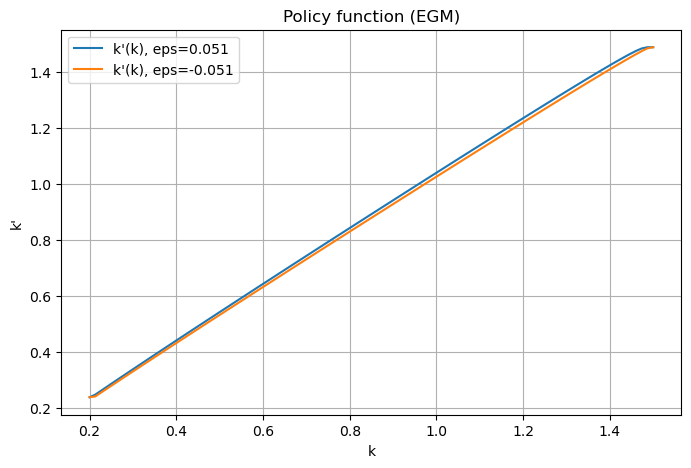

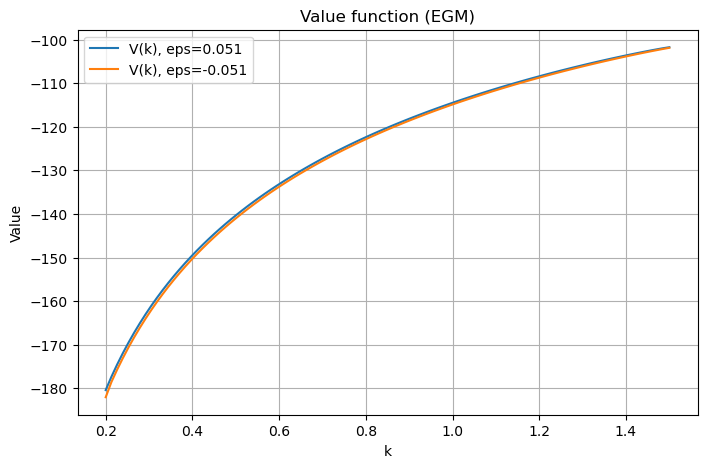

In [5]:
import numpy as np
from scipy.optimize import minimize, brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time

# parameters

beta = 0.96
alpha = 0.33
theta = 1.0
gamma = 2.0
B = 0.075
omega = 2.0
A = 0.592

# shocks and transitions (match earlier parts)
eps_vals = np.array([0.051, -0.051])    # epsilon_1 = 0.051, epsilon_2 = -0.051
pi = np.array([[0.72, 0.28],
               [0.28, 0.72]])           # transition matrix

# capital grid (100 points as required)
nk = 100
k_min, k_max = 0.2, 1.5
k_grid = np.linspace(k_min, k_max, nk)

# tolerances
max_iter = 200
tol_uc = 1e-6


# model functions

def production(k, h, l):
    # f(kh, l) = A (k*h)^alpha * l^(1-alpha)
    return A * (k * h)**alpha * l**(1.0 - alpha)

def depreciation_term(h):
    # (1 - B h^omega / omega) is used as factor in resource constraint
    return (1.0 - B * (h**omega) / omega)

def util(c, l):
    # utility: (c - l^{1+theta}/(1+theta))^{1-gamma} / (1-gamma)
    if c <= 0 or l <= 0 or l >= 1.0:
        return -1e12
    term = c - (l**(1.0 + theta)) / (1.0 + theta)
    if term <= 0:
        return -1e12
    return term**(1.0 - gamma) / (1.0 - gamma)

def marg_u_from_c_and_l(c, l):
    # u_c = (c - l^{1+theta}/(1+theta))^{-gamma}
    return (c - (l**(1.0 + theta)) / (1.0 + theta))**(-gamma)

def c_from_marg_u(uc, l):
    # invert uc to get c: c = uc^{-1/gamma} + l^{1+theta}/(1+theta)
    return uc**(-1.0 / gamma) + (l**(1.0 + theta)) / (1.0 + theta)


# inner optimization for h and l (for each k and epsilon)
# the inner objective in the problem is:
# maximize A (k h)^alpha l^{1-alpha} + k * (1 - B h^omega / omega) e^{-eps} - l^{1+theta}/(1+theta)
# this is independent of k' and so we precompute it on the k-grid.

def solve_h_l_for_k(k_val, eps):
    # joint optimization over h and l (bounds (1e-6, 1))
    def obj(x):
        h, l = x
        if h <= 0 or l <= 0 or l >= 1.0:
            return 1e10
        y = production(k_val, h, l)
        maint = k_val * depreciation_term(h) * np.exp(-eps)
        flow = y + maint - (l**(1.0 + theta)) / (1.0 + theta)
        # maximize flow => minimize negative flow
        return -flow

    x0 = np.array([0.5, 0.5])
    bounds = [(1e-6, 0.999999), (1e-6, 0.999999)]
    res = minimize(obj, x0, bounds=bounds, method='L-BFGS-B', options={'ftol':1e-10})
    if res.success:
        h_opt, l_opt = res.x
    else:
        # fallback
        h_opt, l_opt = 0.2, 0.2
    return float(h_opt), float(l_opt)

# precompute h(k,eps), l(k,eps), y(k,eps) on exogenous k_grid
print("Precomputing inner (h,l) on k-grid ...")
t0 = time.time()
nk_eps = len(eps_vals)
h_grid = np.zeros((nk, nk_eps))
l_grid = np.zeros((nk, nk_eps))
y_grid = np.zeros((nk, nk_eps))
for i, k in enumerate(k_grid):
    for j, eps in enumerate(eps_vals):
        h_opt, l_opt = solve_h_l_for_k(k, eps)
        h_grid[i, j] = h_opt
        l_grid[i, j] = l_opt
        y_grid[i, j] = production(k, h_opt, l_opt)
print("done precompute in {:.2f}s".format(time.time()-t0))


# initial guesses

# initial policy guess: simple proportional rule k' = 0.9*k (matrix with two eps rows)
policy_k = np.tile(0.9 * k_grid.reshape((nk,1)), (1, nk_eps))  # shape (nk, 2)

# initial marginal utilities uc: compute from naive consumption guess
uc_grid = np.zeros((nk, nk_eps))
for i in range(nk):
    for j in range(nk_eps):
        k = k_grid[i]
        h = h_grid[i, j]
        l = l_grid[i, j]
        # naive consumption: output + maint - small investment (0.05)
        c_guess = y_grid[i, j] + k * depreciation_term(h) * np.exp(-eps_vals[j]) - 0.05
        if c_guess <= 1e-8:
            c_guess = 1e-3
        uc_grid[i, j] = marg_u_from_c_and_l(c_guess, l)


# EGM main loop

print("Starting EGM iterations ...")
t0 = time.time()
for it in range(max_iter):
    uc_new = np.copy(uc_grid)    # will fill
    policy_new = np.copy(policy_k)

    # build interpolants for uc and for precomputed h,l,y across k-grid for each eps
    uc_interp = [interp1d(k_grid, uc_grid[:, j], kind='linear', fill_value='extrapolate') for j in range(nk_eps)]
    h_interp = [interp1d(k_grid, h_grid[:, j], kind='linear', fill_value='extrapolate') for j in range(nk_eps)]
    l_interp = [interp1d(k_grid, l_grid[:, j], kind='linear', fill_value='extrapolate') for j in range(nk_eps)]
    y_interp = [interp1d(k_grid, y_grid[:, j], kind='linear', fill_value='extrapolate') for j in range(nk_eps)]

    # for each current epsilon, treat k' on the same grid as the "kprime_grid" for EGM
   
    kprime_grid = k_grid.copy()
    # precompute things at k' for all eps'
    # gross_ret[kp_index, eps_index] = alpha * y'(k')/k' + depreciation_term(h') * exp(-eps')
    gross_ret = np.zeros((nk, nk_eps))
    uc_at_kp = np.zeros((nk, nk_eps))
    for j_eps_next in range(nk_eps):
        for idx_kp, kp in enumerate(kprime_grid):
            hp = h_interp[j_eps_next](kp)
            lp = l_interp[j_eps_next](kp)
            yp = y_interp[j_eps_next](kp)
            gross_ret[idx_kp, j_eps_next] = alpha * (yp / max(kp, 1e-8)) + depreciation_term(hp) * np.exp(-eps_vals[j_eps_next])
            uc_at_kp[idx_kp, j_eps_next] = uc_interp[j_eps_next](kp)

    # now for each current eps and for each candidate k' compute uc_current from Euler RHS,
    # invert to c, then solve residual to find the implied current k (endogenous k)
    # collect endogenous (k_endog -> kprime) pairs for interpolation
    k_endog_pairs = [ [] for _ in range(nk_eps) ]   # list of (k_endog, kprime)
    uc_endog_pairs = [ [] for _ in range(nk_eps) ]

    for j_eps_cur in range(nk_eps):
        eps_cur = eps_vals[j_eps_cur]
        for idx_kp, kp in enumerate(kprime_grid):
            # compute expectation in Euler: E[ uc(k', eps') * gross_ret(k', eps') ]
            rhs = 0.0
            for s in range(nk_eps):
                rhs += pi[j_eps_cur, s] * ( uc_at_kp[idx_kp, s] * gross_ret[idx_kp, s] )
            # current marginal utility by rearranged Euler:
            uc_curr = (beta / np.exp(-eps_cur)) * rhs
            if not np.isfinite(uc_curr) or uc_curr <= 0:
                continue

            # we need to solve for k such that resource constraint holds:
            # c = c_from_marg_u(uc_curr, l(k))  and c = y(k) - kp*exp(-eps_cur) + k*(1 - B h(k)^omega/omega)*exp(-eps_cur)
            def residual(k_guess):
                # get h,l,y at guessed k via interpolation of precomputed arrays
                h_guess = h_interp[j_eps_cur](k_guess)
                l_guess = l_interp[j_eps_cur](k_guess)
                y_guess = y_interp[j_eps_cur](k_guess)
                c_guess = c_from_marg_u(uc_curr, l_guess)
                rhs_res = y_guess - kp * np.exp(-eps_cur) + k_guess * depreciation_term(h_guess) * np.exp(-eps_cur)
                return rhs_res - c_guess

            # bracket root between k_min and k_max
            try:
                f_lo = residual(k_min)
                f_hi = residual(k_max)
            except Exception:
                continue
            if np.isnan(f_lo) or np.isnan(f_hi):
                continue
            if f_lo * f_hi > 0:
                # no sign change: skip this kp (unfeasible) — could consider expanding bracket or fallback
                continue
            try:
                k_endog = brentq(residual, k_min, k_max, xtol=1e-9, rtol=1e-9, maxiter=200)
            except Exception:
                continue

            # store pair
            k_endog_pairs[j_eps_cur].append((k_endog, kp))
            uc_endog_pairs[j_eps_cur].append((k_endog, uc_curr))

    # invert endogenous mapping via interpolation to get policy on exogenous k_grid
    policy_updated = np.zeros_like(policy_k)
    uc_updated = np.copy(uc_grid) * 1.0

    for j_eps in range(nk_eps):
        pairs = k_endog_pairs[j_eps]
        if len(pairs) < 5:
            # not enough points recovered; keep old policy
            policy_updated[:, j_eps] = policy_k[:, j_eps]
            continue

        # sort by k_endog
        pairs = np.array(pairs)
        k_end_all = pairs[:,0]
        kp_all = pairs[:,1]
        sort_idx = np.argsort(k_end_all)
        k_end_sorted = k_end_all[sort_idx]
        kp_sorted = kp_all[sort_idx]

        # build interpolation kp = g(k_end)
        g_interp = interp1d(k_end_sorted, kp_sorted, kind='linear', bounds_error=False,
                            fill_value=(kp_sorted[0], kp_sorted[-1]))

        # update policy on canonical k_grid by evaluating g_interp(k_grid)
        policy_updated[:, j_eps] = g_interp(k_grid)

        # update uc on canonical grid from inverted mapping: compute c and uc for each k (policy applied)
        for i_k, k_val in enumerate(k_grid):
            kp = policy_updated[i_k, j_eps]
            # h and l at current k
            h_cur = h_interp[j_eps](k_val)
            l_cur = l_interp[j_eps](k_val)
            y_cur = y_interp[j_eps](k_val)
            c_val = y_cur - kp * np.exp(-eps_vals[j_eps]) + k_val * depreciation_term(h_cur) * np.exp(-eps_vals[j_eps])
            if c_val <= 0:
                uc_updated[i_k, j_eps] = uc_grid[i_k, j_eps]  # fallback keep old
            else:
                uc_updated[i_k, j_eps] = marg_u_from_c_and_l(c_val, l_cur)

    # measure convergence
    diff = np.max(np.abs(uc_updated - uc_grid))
    policy_k = np.copy(policy_updated)
    uc_grid = np.copy(uc_updated)

    print(f"EGM iter {it+1}: diff_uc = {diff:.3e}, recovered endogenous points per eps = {[len(k_endog_pairs[j]) for j in range(nk_eps)]}")
    if diff < tol_uc:
        print("EGM converged.")
        break

print("EGM finished in {:.2f}s".format(time.time() - t0))


# policy evaluation: compute value function under policy_k (one-shot iterative evaluation)

V = np.zeros((nk, nk_eps))
max_eval_iter = 5000
tol_eval = 1e-8

for eval_it in range(max_eval_iter):
    V_new = np.zeros_like(V)
    for i_k, k in enumerate(k_grid):
        for j_eps in range(nk_eps):
            kp = policy_k[i_k, j_eps]
            # interpolate to nearest index for kp in k_grid
            # use interpolation of V across k-grid to get V(kp, eps')
            # build interpolants for V rows for expectation
            # but we can do a small interpolation here:
            v_next = 0.0
            for s in range(nk_eps):
                V_interp_s = interp1d(k_grid, V[:, s], kind='linear', fill_value='extrapolate')
                v_next += pi[j_eps, s] * V_interp_s(kp)
            # consumption and flow utility
            h_cur = h_interp[j_eps](k)
            l_cur = l_interp[j_eps](k)
            y_cur = y_interp[j_eps](k)
            c = y_cur - kp * np.exp(-eps_vals[j_eps]) + k * depreciation_term(h_cur) * np.exp(-eps_vals[j_eps])
            if c <= 0:
                flow = -1e12
            else:
                flow = util(c, l_cur)
            V_new[i_k, j_eps] = flow + beta * v_next
    diff_eval = np.max(np.abs(V_new - V))
    V = V_new
    if diff_eval < tol_eval:
        print("Policy evaluation converged in", eval_it+1, "steps")
        break


# plots

plt.figure(figsize=(8,5))
for j in range(nk_eps):
    plt.plot(k_grid, policy_k[:, j], label=f"k'(k), eps={eps_vals[j]:.3f}")
plt.xlabel('k')
plt.ylabel("k'")
plt.title("Policy function (EGM)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
for j in range(nk_eps):
    plt.plot(k_grid, V[:, j], label=f"V(k), eps={eps_vals[j]:.3f}")
plt.xlabel('k')
plt.ylabel("Value")
plt.title("Value function (EGM)")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 1.5 MB/s eta 0:00:00a 0:00:01


In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.hp_filter import hpfilter

# === PARAMETERS ===
lambda_hp = 100  # HP filter smoothing parameter for annual data
countries = ['USA', 'DEU']  # country codes from PWT file

# === 1. Load Data ===
# Replace with your actual PWT CSV filename
df = pd.read_excel(r"C:\Users\meganhainsworth\Downloads\pwt1001.xlsx", sheet_name="Data")


# Keep only relevant columns
cols = [
    'countrycode',
    'year',
    'rgdpna',   # Real GDP at constant 2017 national prices
    'rconna',   # Real consumption at constant 2017 national prices
    'rdana',    # Real domestic absorption at constant 2017 national prices
    'emp',      # Number of persons engaged (millions)
    'avh'       # Average annual hours worked per person
]
df = df[cols]

# === 2. Compute Additional Variables ===
df['I'] = df['rdana'] - df['rconna']  # Investment
df['H'] = df['emp'] * df['avh']       # Total hours worked
df['Prod'] = df['rgdpna'] / df['H']   # Output per hour worked

# === 3. Function to detrend and compute stats ===
def compute_stats(country_df):
    variables = ['rgdpna', 'rconna', 'I', 'H', 'Prod']
    cyclical = {}
    stats = []

    # Apply HP filter to log of each series
    for var in variables:
        log_series = np.log(country_df[var])
        cycle, _ = hpfilter(log_series, lamb=lambda_hp)
        cyclical[var] = cycle
    cyclical = pd.DataFrame(cyclical, index=country_df['year'])

    # Output cycle for correlation reference
    y_cycle = cyclical['rgdpna']

    # Compute statistics
    for var in variables:
        std_dev = cyclical[var].std() * 100  # % deviation
        corr_with_y = cyclical[var].corr(y_cycle)
        autocorr = cyclical[var].autocorr(lag=1)
        stats.append([var, std_dev, corr_with_y, autocorr])

    return pd.DataFrame(stats, columns=['Variable', 'StdDev(%)', 'Corr with Y', 'Autocorr'])

# === 4. Run for each country ===
results = {}
for c in countries:
    c_df = df[df['countrycode'] == c].dropna()
    results[c] = compute_stats(c_df)

# === 5. Display results ===
print("\n=== USA ===")
print(results['USA'])
print("\n=== Germany ===")
print(results['DEU'])

# === 6. Save to Excel ===
with pd.ExcelWriter("business_cycle_stats.xlsx") as writer:
    results['USA'].to_excel(writer, sheet_name="USA", index=False)
    results['DEU'].to_excel(writer, sheet_name="Germany", index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\meganhainsworth\\Downloads\\pwt1001.xlsx'